# Informações do dataset

- **work_year**: O ano que o salário foi pago
- **experience_level**: O nível de experiência no trabalho durante o ano
- **employment_type**: O tipo de trabalho 
- **job_title**: O cargo em que atuou durante o ano
- **salary**: Salário total pago no ano
- **salary_currency**: Moeda em que o salário foi pago (no formato ISO 4217)
- **salary_in_usd**: Salário em USD
- **employee_residence**: Endereço de residencia do empregado durante o ano (no formato ISO 3166 para código de país)
- **remote_ratio**: O quanto de trabalho é feito remotamente (0%: local, 50%: hibrido, 100%: todo à distância)
- **company_location**: País em que a empresa se encontra
- **company_size**: Tamanho da empresa baseado na mediana de empregados durante o ano

# Bibliotecas utilizadas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pycountry

# Carregando o arquivo e observando os dados

In [2]:
df = pd.read_csv("./ds_salaries.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


### Temos que o dataset não possui dados nulos

In [4]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


### Algumas colunas, como experience_level e employment_type possuem valores que podem ser dificeis de entender. Portanto, podemos modifica-los para o melhor entendimento da variável. Além disso, as colunas employee_residence e company_location estão no formato ISO 3166. Para facilitar possíveis análises futuras, usaremos a biblioteca pycountry para mostrar o nome dos paises, de forma que fique mais legível

# Arrumando o dataframe para melhor legilibilidade

##  Criar uma coluna chamada "job_category" para agrupar os títulos dos trabalho e obter melhores visualizações

In [7]:
df["job_title"].value_counts() #O dataset possui 93 nomes de trabalhos, agrupa-los em poucas categorias irá melhorar muito a visualização dos dados

job_title
Data Engineer                          1040
Data Scientist                          840
Data Analyst                            612
Machine Learning Engineer               289
Analytics Engineer                      103
                                       ... 
Principal Machine Learning Engineer       1
Azure Data Engineer                       1
Manager Data Management                   1
Marketing Data Engineer                   1
Finance Data Analyst                      1
Name: count, Length: 93, dtype: int64

### As categorias serão feitas a partir dos 4 primeiros resultados (Data Engineer, Data Scientist, Data Analyst, Machine Learning), além dos cargos de gerencia.

In [8]:
#Categoria de gerentes
cat_manager = df['job_title'].str.contains('Manager|Head|Menagement', case=False)
list_cat_manager = df[cat_manager]["job_title"].value_counts().to_dict().keys()

#Categoria de cientistas de dados
cat_scientist = df['job_title'].str.contains('Data Scientist|Science', case=False) & ~df['job_title'].str.contains('Manager|Head|Menagement', case=False)
list_cat_scientist = df[cat_scientist]["job_title"].value_counts().to_dict().keys()

#Categoria de engenheiros de dados
cat_engineer = df['job_title'].str.contains('Data Engineer', case=False) & ~df['job_title'].str.contains('Manager|Head|Menagement', case=False)
list_cat_engineer = df[cat_engineer]["job_title"].value_counts().to_dict().keys()

#Categoria de analistas de dados
cat_analyst = df['job_title'].str.contains('Data Analyst', case=False) & ~df['job_title'].str.contains('Manager|Head|Menagement', case=False)
list_cat_analyst = df[cat_analyst]["job_title"].value_counts().to_dict().keys()

#Categoria de machine learning
cat_machine_learning = df['job_title'].str.contains('Machine Learning|ML', case=False) & ~df['job_title'].str.contains('Manager|Head|Menagement', case=False)
list_cat_machine_learning = df[cat_machine_learning]["job_title"].value_counts().to_dict().keys()


In [9]:
def categories(job):
    if job in list_cat_manager:
        return "Management"
    elif job in list_cat_scientist:
        return "Data Science"
    elif job in list_cat_engineer:
        return "Data Engineering"
    elif job in list_cat_analyst:
        return "Data Analyst"
    elif job in list_cat_machine_learning:
        return "Machine Learning"
    else:
        return "Other"

df["job_category"] = df["job_title"].apply(categories)

## Renomear os valores da coluna "experience_level" para "Senior", "Junior" etc

In [10]:
df["experience_level"].unique()

array(['SE', 'MI', 'EN', 'EX'], dtype=object)

In [11]:
df["experience_level"] = df["experience_level"].replace({"SE": "Senior", "MI": "Intermediate", "EN": "Junior", "EX": "Executive"})
df["experience_level"].unique()

array(['Senior', 'Intermediate', 'Junior', 'Executive'], dtype=object)

## Renomear os valores da coluna "employment_type" para "Full-Time", "Part-Time" etc

In [12]:
df["employment_type"] = df["employment_type"].replace({"FT": "Full-Time", "PT": "Part-Time", "CT": "Contractor", "FL": "Freelancer"})
df["employment_type"].unique()

array(['Full-Time', 'Contractor', 'Freelancer', 'Part-Time'], dtype=object)

## Converter os códigos de países para os nomes dos países

In [13]:
def country_code_to_name(code):
    try:
        country = pycountry.countries.get(alpha_2=code)
        return country.alpha_3
    except:
        return None
    
df['company_location'] = df['company_location'].apply(country_code_to_name)
df['employee_residence'] = df['employee_residence'].apply(country_code_to_name)

In [14]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_category
0,2023,Senior,Full-Time,Principal Data Scientist,80000,EUR,85847,ESP,100,ESP,L,Data Science
1,2023,Intermediate,Contractor,ML Engineer,30000,USD,30000,USA,100,USA,S,Machine Learning
2,2023,Intermediate,Contractor,ML Engineer,25500,USD,25500,USA,100,USA,S,Machine Learning
3,2023,Senior,Full-Time,Data Scientist,175000,USD,175000,CAN,100,CAN,M,Data Science
4,2023,Senior,Full-Time,Data Scientist,120000,USD,120000,CAN,100,CAN,M,Data Science


# Com o dataset limpo e modificado, é possível realizar a EDA

## Porcentagem das categorias de trabalho no dataset

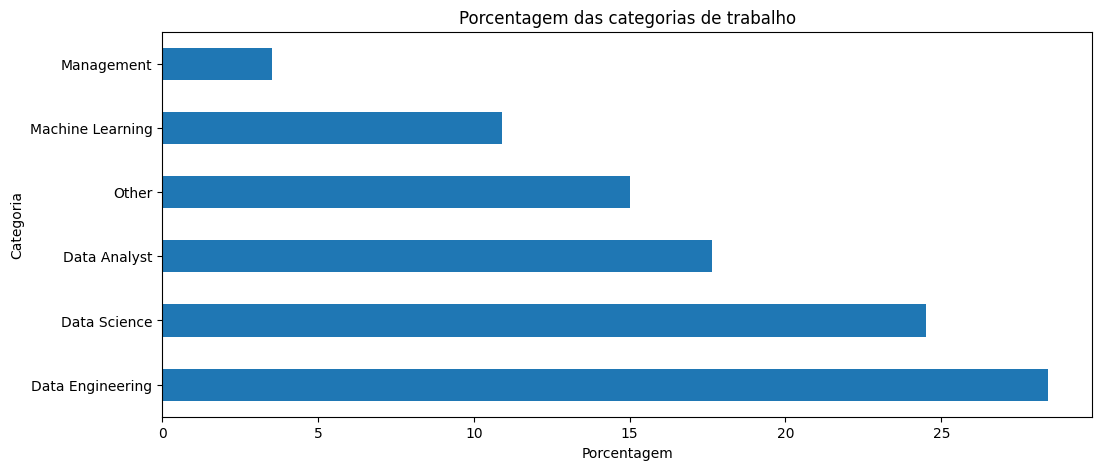

In [15]:
job_categories = round(df["job_category"].value_counts(normalize=100)*100, 2)
ax = job_categories.plot.barh(figsize=(12, 5))
ax.set_ylabel("Categoria")
ax.set_xlabel("Porcentagem")
ax.set_title("Porcentagem das categorias de trabalho")
plt.show()

### Observa-se que as categorias de engenharia de dados e ciência de dados juntas somam mais que 50% dos dados, indicando uma alta popularidade dessas áreas.

## Frequencia das categorias de trabalho por ano

In [16]:
tables = []
for year in df.work_year.unique():
    year_df = df[df.work_year == year]
    table = pd.crosstab(year_df.job_category, columns='count')
    table.columns = [f'{year}']
    tables.append(table)
all_tables = pd.concat(tables, axis=1)
all_tables = all_tables.reindex(columns=["2020", "2021", "2022", "2023"])

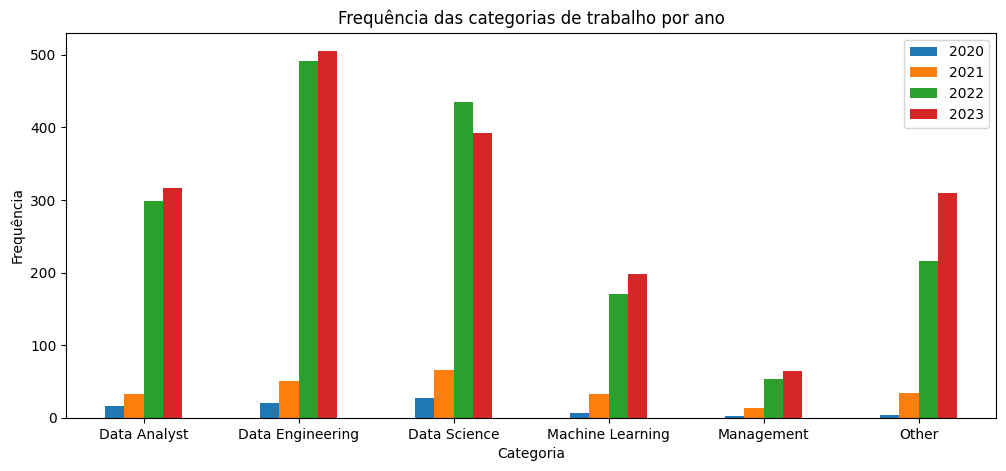

In [17]:
ax = all_tables.plot.bar(figsize=(12,5))
ax.set_xlabel('Categoria')
ax.set_ylabel('Frequência')
ax.set_title('Frequência das categorias de trabalho por ano')
ax.grid(False)
plt.xticks(rotation=0)
plt.show()

### Podemos ver que a partir de 2022, houve uma alta absurda de vagas no mercado. Uma das razões para isso pode ter sido a pandemia, onde todos estavam em casa e constantemente utilizando serviços online, realizando compras e afins. Com isso, as empresas perceberam que precisavam aumentar o tamanho e a qualidade do seus setores de dados e as empresas que não possuíam uma estrutura para dados, percebeu uma oportunidade de crescimento ao melhorar esse setor. Assim, o mercado se aqueceu muito, com o número de vagas e cargos crescendo exponencialmente
### Outro ponto é que as categorias de engenharia de dados e ciência de dados foram as que mais abriram vagas e contratações, confirmando a popularidade dessas áreas. Um ponto interessante também de se notar é que a categoria "outros", no ano de 2023, teve quase o mesmo número de vagas abertas da categoria de analise de dados

## Análise dos Salários

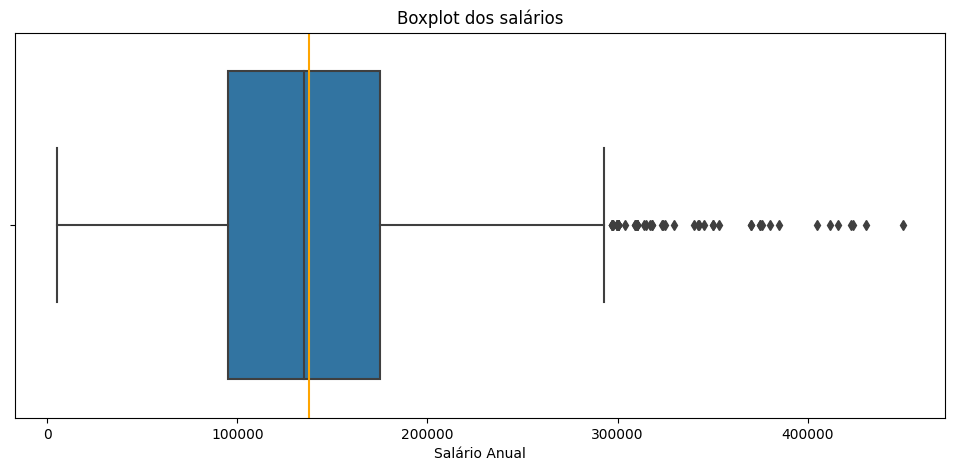

count      3755.00
mean     137570.39
std       63055.63
min        5132.00
25%       95000.00
50%      135000.00
75%      175000.00
max      450000.00
Name: salary_in_usd, dtype: float64

In [18]:
plt.figure(figsize=(12, 5))
ax = sns.boxplot(x=df["salary_in_usd"])
ax.set_xlabel("Salário Anual")
ax.grid(False)
ax.axvline(df["salary_in_usd"].mean(), color=("Orange"))
ax.set_title("Boxplot dos salários")
plt.show()
display(df["salary_in_usd"].describe().round(2))

### A distribuição dos salários, de forma geral, lembra uma distribuição normal. A linha laranja é a média salárial e ela é quase igual a mediana dos salários, representada pela linha no meio do boxplot. Além disso, existem outliers mas não em uma quantidade muito alta

## Mediana dos salários por ano em cada categoria

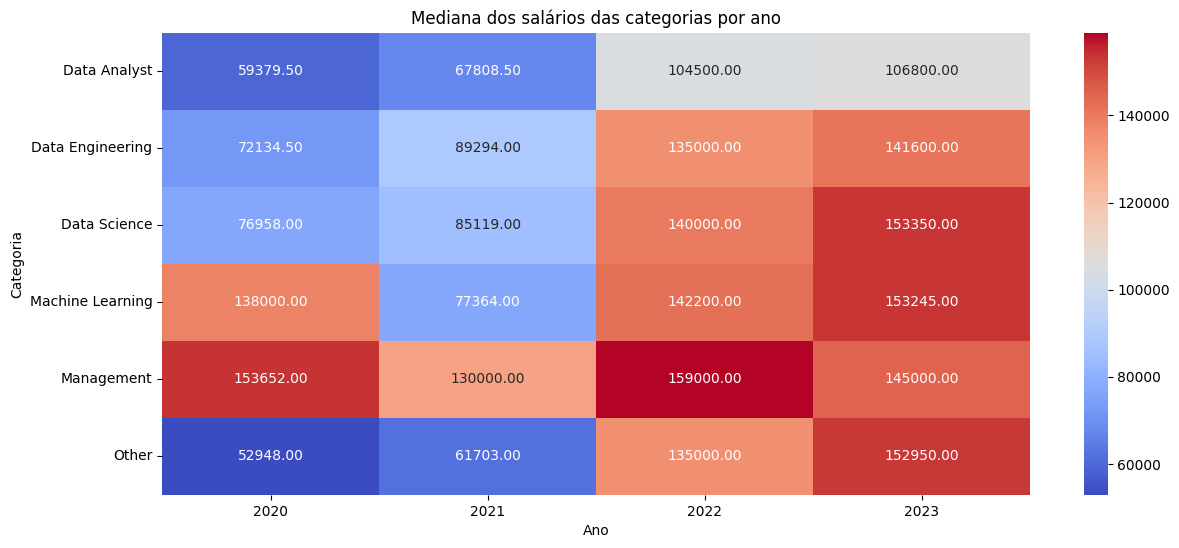

In [24]:
plt.figure(figsize=(14,6))
median_salary_year = df.pivot_table(values='salary_in_usd', index='job_category', columns='work_year', aggfunc='median')
sns.heatmap(median_salary_year, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Mediana dos salários das categorias por ano')
plt.ylabel("Categoria")
plt.xlabel("Ano")
plt.xticks(rotation=0)
ax.grid(False)
plt.show()

### Utilizamos a mediana aqui para se aproximar do valor real de aumento ou diminuição do salário da categoria com o passar dos anos, poís é menos afetada por valores que sejam muito mais altos ou mais baixos que o normal.
### Como é possível observar pelo mapa de calor, as duas principais categorias, engenharia de dados e ciência de dados, tiveram os salários dobrados no período de 2020 até 2023, sendo mais um fator que explique a maior popularidade dessas categorias. Além disso, a categoria "outros" chama a atenção, tendo seu salário triplicado nesse período, podendo ser um motivo para que no ano de 2023, essa categoria estivesse empatando com a categoria de análise de dados (que não obteve um aumento salarial relevante em comparação com as outras citadas) no quesito de vagas e contratações, mostrados nos gráficos anteriores

## Boxplot dos salários por categoria de trabalho

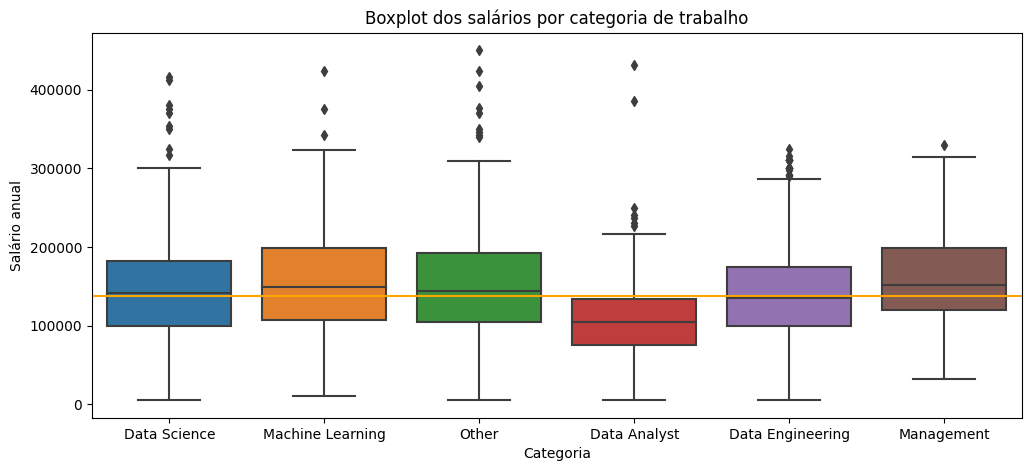

In [20]:
plt.figure(figsize=(12, 5))
ax = sns.boxplot(data=df, x="job_category", y="salary_in_usd")
ax.set_xlabel("Categoria")
ax.set_ylabel("Salário anual")
ax.grid(False)
ax.axhline(df["salary_in_usd"].mean(), color=("Orange"))
ax.set_title("Boxplot dos salários por categoria de trabalho")
plt.show()

### As duas categorias mais populares possuem salários que estão bem na média salarial do dataframe, assim como a categoria "outros". Machine learning e gerencia possuem os maiores salários, com gerência obviamente possuindo os maiores salários dentre todas as categorias e a categoria de análise de dados é a única que recebe abaixo da média salarial.

## Boxplot dos salários por tipo de trabalho

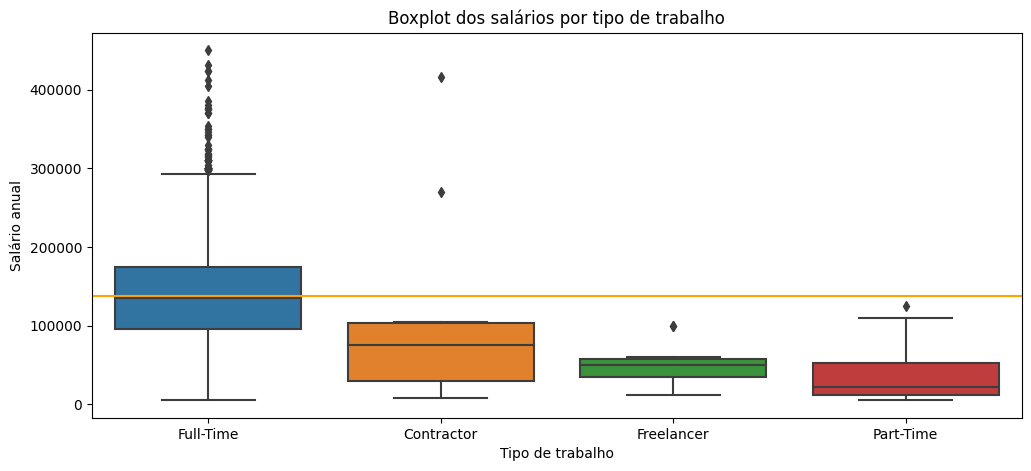

In [25]:
plt.figure(figsize=(12, 5))
ax = sns.boxplot(data=df, x="employment_type", y="salary_in_usd")
ax.set_xlabel("Tipo de trabalho")
ax.set_ylabel("Salário anual")
ax.grid(False)
ax.axhline(df["salary_in_usd"].mean(), color=("Orange"))
ax.set_title("Boxplot dos salários por tipo de trabalho")
plt.show()

### Podemos observar que trabalhar em tempo integral é o único tipo que recebe na média salarial.

## Médiana salarial por tipo de trabalho e ano

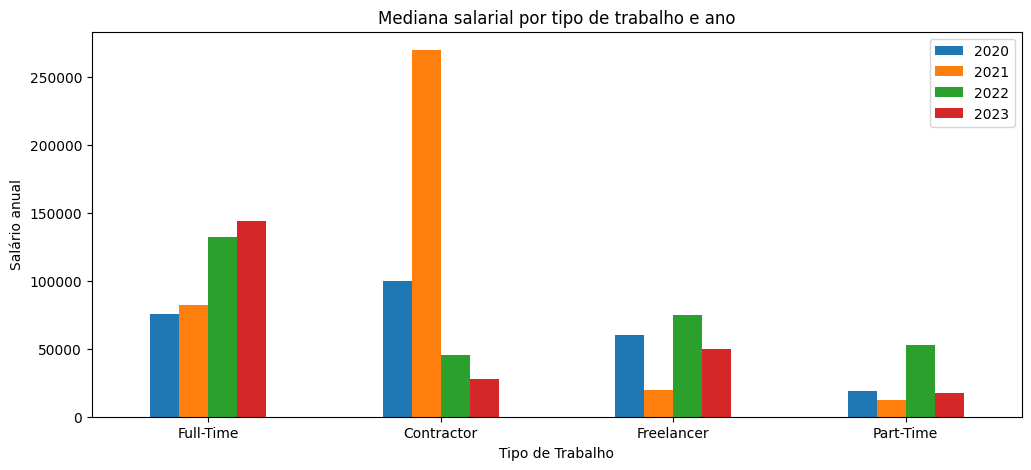

In [28]:
avg_salary_work = df.pivot_table(values='salary_in_usd', index='employment_type', columns='work_year', aggfunc='median')
order = ["Full-Time", "Contractor", "Freelancer", "Part-Time"]
avg_salary_work = avg_salary_work.reindex(order)
ax = avg_salary_work.plot.bar(figsize=(12,5))
ax.set_xlabel('Tipo de Trabalho')
ax.set_ylabel('Salário anual')
ax.set_title('Mediana salarial por tipo de trabalho e ano')
ax.grid(False)
plt.xticks(rotation=0)
ax.get_legend().set_title('')
plt.show()

### Ao olhar a mediana salarial por trabalho e ano, vemos algo interessante. Quem trabalhava sendo contratado por fora pela empresa, teve um ganho salarial massivo no ano de 2021. Talvez isso tenha ocorrido pois esse ano foi o auge da pandemia, e as empresas começaram a notar que precisavam aumentar e melhor seus setores de dados. Como a demanda começou a aumentar por pessoas que conseguissem realizar isso e elas eram poucas, elas podiam negociar valores muito mais altos que o normal do mercado e trabalhar sem exclusividade, podendo ter contrato com mais de uma empresa.
### A partir de 2022, quando o número de vagas aumentou exponencialmente e essas vagas foram sendo preenchidas, os salários daqueles que trabalham em tempo integral basicamente dobrou, e como as empresas conseguiram suprir a demanda por uma boa estrutura de dados, os salários daqueles que trabalhavam de forma terceirizada cairam para os níveis de freelancer e meio período

## Médiana salarial por experiência e ano

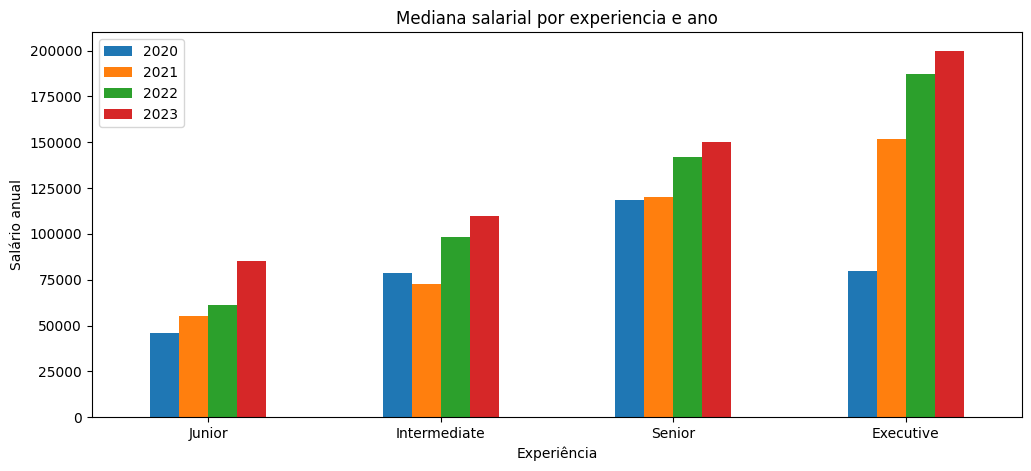

In [42]:
median_salary_experience = df.pivot_table(values='salary_in_usd', index='experience_level', columns='work_year', aggfunc='median')
order = ["Junior", "Intermediate", "Senior", "Executive"]
median_salary_experience = median_salary_experience.reindex(order)
ax = median_salary_experience.plot.bar(figsize=(12,5))
ax.set_xlabel('Experiência')
ax.set_ylabel('Salário anual')
ax.set_title('Mediana salarial por experiencia e ano')
ax.grid(False)
plt.xticks(rotation=0)
ax.get_legend().set_title('')
plt.show()

### Podemos ver que cada nível de experiência teve um aumento de salário com o passar dos anos, indicando que as empresas estão faturando mais e que o mercado ainda está crescendo

## Salário médio por país do empregado

In [38]:
avg_salary_country = df.groupby("employee_residence", as_index=False)["salary_in_usd"].mean()
avg_salary_country = avg_salary_country[avg_salary_country["employee_residence"] != "ISR"]
fig = px.choropleth(avg_salary_country,
                    locations = avg_salary_country.employee_residence, 
                    color = avg_salary_country.salary_in_usd,                 
                    labels={"employee_residence": "País", "salary_in_usd": "Média salarial em USD"},
                    title="Média salarial por país do empregado")
fig.update_layout(
    margin=dict(t=50, r=0, l=0, b=0),
    height=350,
    width=770,
    geo_projection=dict(scale=1.2),
    title=dict(font=dict(color='black'), x=0.5),
    coloraxis=dict(
        colorbar=dict(tickfont=dict(color='black'),title=dict(text='', font=dict(color='black'))))
)
fig.show()


### Ao analisar o salário médio anual por país, temos que os estados unidos possuem os maiores salários junto do canadá.

## Trabalho remoto por país do empregado

In [39]:
remote_ratio_employee_country = df.groupby("employee_residence", as_index=False)["remote_ratio"].mean()
fig = px.choropleth(remote_ratio_employee_country,
                    locations = remote_ratio_employee_country.employee_residence, 
                    color = remote_ratio_employee_country.remote_ratio,                 
                    labels={"employee_residence": "País", "remote_ratio": "Taxa de trabalho remoto"},
                    title="Taxa de trabalho remoto por país do empregado")
fig.update_layout(
    margin=dict(t=50, r=0, l=0, b=0),
    height=350,
    width=770,
    geo_projection=dict(scale=1.2),
    title=dict(font=dict(color='black'), x=0.5),
    coloraxis=dict(
        colorbar=dict(tickfont=dict(color='black'),title=dict(text='', font=dict(color='black'))))
)
fig.show()

### Ao comparar esse gráfico com o gráfico de salários por país, temos que os países que possuem salários mais baixos são aqueles onde os empregados costumam buscar mais pelo trabalho remoto, possibilitando o trabalho em empresas de fora.

## Trabalho remoto por país da empresa

In [40]:
remote_ratio_company_country = df.groupby("company_location", as_index=False)["remote_ratio"].mean()
fig = px.choropleth(remote_ratio_company_country,
                    locations = remote_ratio_company_country.company_location, 
                    color = remote_ratio_company_country.remote_ratio,                 
                    labels={"company_location": "País", "remote_ratio": "Taxa de trabalho remoto"},
                    title="Taxa de trabalho remoto por país da empresa")
fig.update_layout(
    margin=dict(t=50, r=0, l=0, b=0),
    height=350,
    width=770,
    geo_projection=dict(scale=1.2),
    title=dict(font=dict(color='black'), x=0.5),
    coloraxis=dict(
        colorbar=dict(tickfont=dict(color='black'),title=dict(text='', font=dict(color='black'))))
)
fig.show()

### O mesmo se nota na taxa de trabalho remoto por país da empresa, onde empresas de países com salários mais baixos tendem a preferir contratar pessoas de forma remota

## Diferença salarial entre presencial, remoto e hibrido

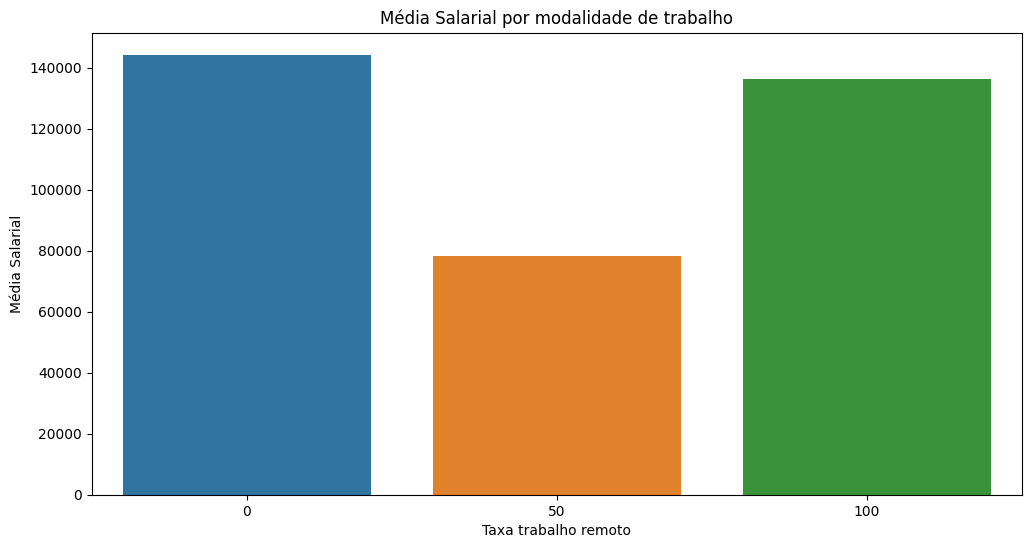

In [25]:
teste = df.groupby("remote_ratio", as_index=False)["salary_in_usd"].mean()
plt.figure(figsize=(12,6))
sns.barplot(data=teste, x="remote_ratio", y="salary_in_usd")
plt.xlabel("Taxa trabalho remoto")
plt.ylabel("Média Salarial")
plt.title("Média Salarial por modalidade de trabalho")
plt.show()

### Como é possível observar, a diferença entre quem trabalha presencialmente e remotamente é bem baixa, mas deve-se levar em consideração que quem trabalha presencialmente possui custos de transporte e tempo de locomoção entre casa e trabalho. Um dado interessante é que trabalhar no modelo híbrido, nesse dataset, não é algo ideal, tendo uma média salarial quase que 50% menor em relação as outras modalidades